In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.signal import find_peaks,peak_widths
import os, sys, re, copy, math
from tqdm.auto import tqdm

print(Path.cwd().parent)
sys.path.append(str(Path.cwd().parent) + '/photutils/')
from bandpass import Bandpass
from signaltonoise import calc_mag_error_m5
from photometric_parameters import PhotometricParameters

#astropy 
import astropy.units as u
from astropy import constants as const
from astropy.table import QTable
from astropy.time import Time
from astropy.coordinates import SkyCoord

#pyLIMA
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.toolbox import time_series
from pyLIMA.simulations import simulator
from pyLIMA.models import PSBL_model
from pyLIMA.models import USBL_model
from pyLIMA.models import FSPLarge_model
from pyLIMA.models import PSPL_model
from pyLIMA.fits import TRF_fit
from pyLIMA.fits import DE_fit
from pyLIMA.fits import MCMC_fit
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA.outputs import file_outputs

import multiprocessing as mul
import h5py

/home/anibal/roman_rubin


In [2]:
# np.linspace(0,1,20)

In [3]:
# LSST_BandPass = {}
# lsst_filterlist = 'ugrizy'
# for f in lsst_filterlist:
#     LSST_BandPass[f] = Bandpass()
#     LSST_BandPass[f].read_throughput('/home/anibal/che/archive/troughputs/'+ f'total_{f}.dat')
# photParams = set_photometric_parameters(15, 2)
# m5 = 22
# magerr = calc_mag_error_m5(20, LSST_BandPass['u'], m5, photParams)[0]
# magerr

In [4]:
def tel_roman_rubin(path_ephemerides, path_dataslice):
    '''
    :param opsim:
    :return:
    '''
    gc = SkyCoord(l=0.5*u.degree, b=-1.25*u.degree, frame='galactic')
    gc.icrs.dec.value
    Ra = gc.icrs.ra.value
    Dec = gc.icrs.dec.value
    LSST_BandPass = {}
    lsst_filterlist = 'ugrizy'
    for f in lsst_filterlist:
        LSST_BandPass[f] = Bandpass()
        LSST_BandPass[f].read_throughput('/home/anibal/che/archive/troughputs/'+ f'total_{f}.dat')
    dataSlice = np.load(path_dataslice, allow_pickle=True)
    rubin_ts = {}
    for fil in lsst_filterlist:
        m5 = dataSlice['fiveSigmaDepth'][np.where(dataSlice['filter'] == fil)]
        mjd = dataSlice['observationStartMJD'][np.where(dataSlice['filter'] == fil)]+2400000.5
        int_array = np.column_stack((mjd, m5, m5)).astype(float)
        rubin_ts[fil] = int_array

    tlsst =60413.26382860778 +2400000.5
    tstart_Roman = 2461508.763828608 #tlsst + 3*365 #Roman is expected to be launch in may 2027

    my_own_creation = event.Event(ra=Ra, dec=Dec)
    my_own_creation.name = 'An event observed by Roman'
    nominal_seasons = [
        {'start': '2027-02-11T00:00:00', 'end': '2027-04-24T00:00:00'},
        {'start': '2027-08-16T00:00:00', 'end': '2027-10-27T00:00:00'},
        {'start': '2028-02-11T00:00:00', 'end': '2028-04-24T00:00:00'},
        {'start': '2030-02-11T00:00:00', 'end': '2030-04-24T00:00:00'},
        {'start': '2030-08-16T00:00:00', 'end': '2030-10-27T00:00:00'},
        {'start': '2031-02-11T00:00:00', 'end': '2031-04-24T00:00:00'},
    ]
    Roman_tot = simulator.simulate_a_telescope(name='W149',
                                               time_start=tstart_Roman + 107 + 72 * 5 + 113 * 2 + 838.36 + 107,
                                               time_end=tstart_Roman + 107 + 72 * 5 + 113 * 2 + 838.36 + 107 + 72,
                                               sampling=0.25,
                                               location='Space', camera_filter='W149', uniform_sampling=True,
                                               astrometry=False)
    lightcurve_fluxes=[]
    for season in nominal_seasons:
        tstart = Time(season['start'], format='isot').jd
        tend = Time(season['end'], format='isot').jd
        Roman = simulator.simulate_a_telescope(name='W149', 
                                               time_start=tstart, 
                                               time_end=tend, 
                                               sampling=0.25,
                                               location='Space', 
                                               camera_filter='W149', 
                                               uniform_sampling=True, 
                                               astrometry=False)
        lightcurve_fluxes.append(Roman.lightcurve_flux)
    # Combine all the lightcurve_flux tables into one array
    combined_array = np.concatenate([lc.as_array() for lc in lightcurve_fluxes])
    # Convert the combined array back into a QTable
    new_table = QTable(combined_array, names=['time', 'flux', 'err_flux'], units=['JD', 'W/m^2', 'W/m^2'])

    Roman_tot.lightcurve_flux = new_table
    ephemerides = np.loadtxt(path_ephemerides)
    ephemerides[:,0] = ephemerides[:,0]
    ephemerides[:,3] *=  60*300000/150000000
    deltaT = tlsst-ephemerides[:,0][0]
    ephemerides[:,0] = ephemerides[:,0]+deltaT
    Roman_tot.location = 'Space'
    Roman_tot.spacecraft_name = 'WFIRST_W149'
    Roman_tot.spacecraft_positions = {'astrometry':[],'photometry': ephemerides}
    my_own_creation.telescopes.append(Roman_tot)

    for band in lsst_filterlist:
        lsst_telescope = telescopes.Telescope(name=band, camera_filter=band, location='Earth',
                                              light_curve=rubin_ts[band],
                                              light_curve_names=['time', 'mag', 'err_mag'],
                                              light_curve_units=['JD', 'mag', 'mag'])
        my_own_creation.telescopes.append(lsst_telescope)

    return my_own_creation, dataSlice, LSST_BandPass

def deviation_from_constant(pyLIMA_parameters, pyLIMA_telescopes):
    '''
     There at least four points in the range
     $[t_0-tE, t_0+t_E]$ with the magnification deviating from the
     constant flux by more than 3$\sigma$
    '''
    ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
          'i':27.85, 'z':27.46, 'y':26.68}
    t0=pyLIMA_parameters['t0']
    tE=pyLIMA_parameters['tE']
    satis_crit={}
    for telo in pyLIMA_telescopes:
        if not len(telo.lightcurve_magnitude['mag'])==0:
            mag_baseline = ZP[telo.name]-2.5*np.log10(pyLIMA_parameters['ftotal_'+f'{telo.name}'])
            x = telo.lightcurve_magnitude['time'].value
            y = telo.lightcurve_magnitude['mag'].value
            z = telo.lightcurve_magnitude['err_mag'].value
            mask = (t0-tE<x)&(x<t0+tE)
            consec = []
            if len(x[mask])>=3:
                combined_lists = list(zip(x[mask], y[mask], z[mask]))
                sorted_lists = sorted(combined_lists, key=lambda item: item[0])
                sorted_x, sorted_y, sorted_z = zip(*sorted_lists)
                for j in range(len(sorted_y)):
                    if sorted_y[j] + 3 * sorted_z[j] < mag_baseline:
                        consec.append(j)
                result = has_consecutive_numbers(consec)
                if result:
                    satis_crit[telo.name]=True
                else:
                    satis_crit[telo.name]=False
            else:
                satis_crit[telo.name]=False
        else:
            satis_crit[telo.name]=False
    return any(satis_crit.values())
            
def filter5points(pyLIMA_parameters, pyLIMA_telescopes):
    '''
    Check that at least one light curve
    have at least 5 pts in the t0+-tE
    '''
    t0=pyLIMA_parameters['t0']
    tE=pyLIMA_parameters['tE']
    crit5pts={}
    for telo in pyLIMA_telescopes:
        if not len(telo.lightcurve_magnitude['mag'])==0:
            x = telo.lightcurve_magnitude['time'].value
            mask = (t0-tE<x)&(x<t0+tE)
            if len(x[mask])>=5:
                crit5pts[telo.name] = True
            else:
                crit5pts[telo.name] = False
    return any(crit5pts.values())

def mag(zp, Flux):
    '''
    Transform the flux to magnitude
    inputs
    zp: zero point
    Flux: vector that contains the lightcurve flux
    '''
    return zp - 2.5 * np.log10(abs(Flux))


def filter_band(mjd, mag, magerr, m5, fil):
    '''
    *Save the points of the lightcurve greater and smaller than
      1sigma fainter and brighter that the saturation and 5sigma_depth
    * check that the lightcurve have more than 10 points
    * check if the lightcurve have at least 1 point at 5 sigma from the 5sigma_depth
    '''
    mag_sat = {'W149': 14.8, 'u': 14.7, 'g': 15.7, 'r': 15.8, 'i': 15.8, 'z': 15.3, 'y': 13.9}
    MJD = []
    MAG = []
    MAGERR = []
    M5 = []
    five_sigmas = False
    for i in range(len(mjd)):
        if (mag[i] - magerr[i] > mag_sat[fil]) and (mag[i] + magerr[i] < m5[i]):
            MJD.append(mjd[i])
            MAGERR.append(magerr[i])
            MAG.append(mag[i])
            M5.append(m5[i])
        elif mag[i] + 5 * magerr[i] < m5[i]:
            five_sigmas = True

    if not len(MAG) > 10:
        MJD, MAG, MAGERR, M5 = [], [], [], []
    return MJD, MAG, MAGERR, M5


def has_consecutive_numbers(lst):
    """
    check if there at least 3 consecutive numbers in a list lst
    """
    sorted_lst = sorted(lst)
    for i in range(len(sorted_lst) - 2):
        if sorted_lst[i] + 1 == sorted_lst[i + 1] == sorted_lst[i + 2]-1:
            return True
    return False
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams


def fit_rubin_roman(Source,event_params, path_save, path_ephemerides,model, algo, Origin, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y):
    '''
    Perform fit for Rubin and Roman data for fspl, usbl and pspl
    '''
    tlsst = 60350.38482057137 + 2400000.5
    RA, DEC = 267.92497054815516, -29.152232510353276
    e = event.Event(ra=RA, dec=DEC)

    if len(lsst_u) + len(lsst_g) + len(lsst_r) + len(lsst_i) + len(lsst_z) + len(lsst_y) == 0:
        e.name = 'Event_Roman_' + str(int(Source))
    else:
        e.name = 'Event_RR_' + str(int(Source))
    tel_list = []

    # Add a PyLIMA telescope object to the event with the Gaia lightcurve
    tel1 = telescopes.Telescope(name='Roman', camera_filter='W149',
                                light_curve=wfirst_lc,
                                light_curve_names=['time', 'mag', 'err_mag'],
                                light_curve_units=['JD', 'mag', 'mag'],
                                location='Space')

    ephemerides = np.loadtxt(path_ephemerides)
    ephemerides[:, 0] = ephemerides[:, 0]
    ephemerides[:, 3] *= 60 * 300000 / 150000000
    deltaT = tlsst - ephemerides[:, 0][0]
    ephemerides[:, 0] = ephemerides[:, 0] + deltaT
    tel1.spacecraft_positions = {'astrometry': [], 'photometry': ephemerides}
    e.telescopes.append(tel1)
    tel_list.append('Roman')
    
    lsst_lc_list = [lsst_u,lsst_g,lsst_r,lsst_i,lsst_z,lsst_y]
    lsst_bands = "ugrizy"
    for j in range(len(lsst_lc_list)):
        if not len(lsst_lc_list[j])==0:
            tel = telescopes.Telescope(name=lsst_bands[j], camera_filter=lsst_bands[j],
                                light_curve=lsst_lc_list[j],
                                light_curve_names=['time', 'mag', 'err_mag'],
                                light_curve_units=['JD', 'mag', 'mag'],
                                location='Earth')
            e.telescopes.append(tel)
            tel_list.append(lsst_bands[j])
    e.check_event()
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    t0 = float(event_params['t0'])
    u0 = float(event_params['u0'])
    tE = float(event_params['te'])
    rho = float(event_params['rho'])
    piEN = float(event_params['piEN'])
    piEE = float(event_params['piEE'])
    s = float(event_params['s'])
    q = float(event_params['q'])
    alpha = float(event_params['alpha'])
    
    rango = 0.5
    if model == 'FSPL':
        pyLIMAmodel = FSPLarge_model.FSPLargemodel(e, parallax=['Full', t0])
        param_guess = [t0, u0, tE, rho, piEN, piEE]
    elif model=='USBL':
        pyLIMAmodel = USBL_model.USBLmodel(e, blend_flux_parameter='ftotal', parallax=['Full', t0])
        # pyLIMAmodel = USBL_model.USBLmodel(e, origin=Origin,
        #                                    blend_flux_parameter='ftotal',
        #                                    parallax=['Full', t0])
        param_guess = [t0, u0, tE, rho, s, q, alpha, piEN, piEE]
    elif model=='PSPL':
        pyLIMAmodel = PSPL_model.PSPLmodel(e, parallax=['Full', t0])
        param_guess = [t0, u0, tE, piEN, piEE]
        
    if algo == 'TRF':
        fit_2 = TRF_fit.TRFfit(pyLIMAmodel)
        pool=None
    elif algo == 'MCMC':
        fit_2 = MCMC_fit.MCMCfit(pyLIMAmodel, MCMC_links=5000)
        pool = mul.Pool(processes = 32)
    elif algo == 'DE':
        fit_2 = DE_fit.DEfit(pyLIMAmodel, telescopes_fluxes_method='polyfit', DE_population_size=20, max_iteration=10000,
                             display_progress=True)
        
    fit_2.model_parameters_guess = param_guess
    
    if model =='USBL':
        fit_2.fit_parameters['separation'][1] = [s - np.abs(s) * rango, s + np.abs(s) * rango]
        fit_2.fit_parameters['mass_ratio'][1] = [q - rango * q, q + rango * q]
        fit_2.fit_parameters['alpha'][1] = [0, np.pi]
    
    if (model =='USBL') or (model =='FSPL'):
        fit_2.fit_parameters['rho'][1] = [0, rho + rango * abs(rho)]
    
    # fit_2.fit_parameters['t0'][1] = [t0 - 10, t0 + 10]  # t0 limits
    # fit_2.fit_parameters['u0'][1] = [u0 - abs(u0) * rango, u0 + abs(u0) * rango]  # u0 limits
    fit_2.fit_parameters['tE'][1] = [tE - tE * rango, tE + tE * rango]  # tE limits in days
    fit_2.fit_parameters['piEE'][1] = [piEE - rango * abs(piEE),
                                       piEE + rango * abs(piEE)]  # parallax vector parameter boundaries
    fit_2.fit_parameters['piEN'][1] = [piEN - rango * abs(piEN),
                                       piEN + rango * abs(piEN)]  # parallax vector parameter boundaries
    
    if algo=="MCMC":
        fit_2.fit(computational_pool = pool)
    else:
        fit_2.fit()

    true_values = np.array(event_params)
    fit_2.fit_results['true_params'] = event_params
    np.save(path_save + e.name + '_'+algo+'.npy', fit_2.fit_results)
    return fit_2, e, pyLIMAmodel

def save(iloc, path_TRILEGAL_set, path_to_save, my_own_model, pyLIMA_parameters):
    print('saving...')
    # Save to an HDF5 file with specified names
    with h5py.File(path_to_save + 'Event_' + str(iloc) + '.h5', 'w') as file:
        # Save array with a specified name
        file.create_dataset('Data', data=np.array([iloc, path_TRILEGAL_set, my_own_model.origin[0]], dtype='S'))
        # Save dictionary with a specified name
        dict_group = file.create_group('pyLIMA_parameters')
        for key, value in pyLIMA_parameters.items():
            dict_group.attrs[key] = value
        # Save table with a specified name
        for telo in my_own_model.event.telescopes:
            table = telo.lightcurve_magnitude
            table_group = file.create_group(telo.name)
            for col in table.colnames:
                table_group.create_dataset(col, data=table[col])
                
                
def read_data(path_model):
    # Open the HDF5 file and load data using specified names
    with h5py.File(path_model, 'r') as file:
        # Load array with string with info of dataset using its name
        info_dataset = file['Data'][:]
        info_dataset = [file['Data'][:][0].decode('UTF-8'),file['Data'][:][1].decode('UTF-8'),
                        [file['Data'][:][2].decode('UTF-8'),[0,0]]]
        # Dictionary using its name
        pyLIMA_parameters = {key: file['pyLIMA_parameters'].attrs[key] for key in file['pyLIMA_parameters'].attrs}
        # Load table using its name
        bands={}
        for band in ("W149","u","g","r","i","z","y"):
            loaded_table = QTable()
            for col in file[band]:
                loaded_table[col] = file[band][col][:]
            bands[band]=loaded_table
        return info_dataset, pyLIMA_parameters, bands

def sim_event(i, data, path_ephemerides, path_dataslice, model):
    '''
    i (int): index of the TRILEGAL data set
    data (dictionary): parameters including magnitude of the stars
    path_ephemerides (str): path to the ephemeris of Gaia
    path_dataslice(str): path to the dataslice obtained from OpSims
    model(str): model desired
    '''
    magstar = {'W149':data["W149"], 'u':data["u"], 'g':data["g"], 'r':data["r"],
               'i':data["i"], 'z':data["z"], 'y':data["Y"]}
    ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
              'i':27.85, 'z':27.46, 'y':26.68}
    my_own_creation, dataSlice, LSST_BandPass = tel_roman_rubin(path_ephemerides,
                                                                path_dataslice)
    photParams = set_photometric_parameters(15, 2)
    new_creation = copy.deepcopy(my_own_creation)
    np.random.seed(i)
    t0 = data['t0']
    tE = data['te']
    if model == 'USBL':
        params = {'t0': data['t0'], 'u0': data['u0'], 'tE': data['te'], 'rho': data['rho'],
                  's': data['s'],'q': data['q'], 'alpha': data['alpha'],
                  'piEN': data['piEN'], 'piEE': data['piEE']}
        choice = np.random.choice(["central_caustic", "second_caustic", "third_caustic"])
        # usbl = pyLIMA.models.USBL_model.USBLmodel(roman_event, origin=[choice, [0, 0]],blend_flux_parameter='ftotal')
        my_own_model = USBL_model.USBLmodel(new_creation,origin=["third_caustic", [0, 0]],
                                            blend_flux_parameter='ftotal',
                                            parallax=['Full', t0])
        print(my_own_model.origin)
        # my_own_model = USBL_model.USBLmodel(new_creation,origin=[choice, [0, 0]], parallax=['Full', t0])
    elif model == 'FSPL':
        params = {'t0': data['t0'], 'u0': data['u0'], 'tE': data['te'],
                  'rho': data['rho'], 'piEN': data['piEN'],
                  'piEE': data['piEE']}
        my_own_model = FSPLarge_model.FSPLargemodel(new_creation, parallax=['Full', t0])
    elif model == 'PSPL':
        params = {'t0': data['t0'], 'u0': data['u0'], 'tE': data['te'],
                  'piEN': data['piEN'], 'piEE': data['piEE']}
        my_own_model = PSPL_model.PSPLmodel(new_creation, parallax=['Full', t0])

    my_own_parameters = []
    for key in params:
        my_own_parameters.append(params[key])

    my_own_flux_parameters=[]
    fs, G ,F= {},{},{}
    np.random.seed(i)
    for band in magstar:
        flux_baseline = 10 ** ((ZP[band] - magstar[band]) / 2.5)
        g = np.random.uniform(0, 1)
        f_source = flux_baseline / (1 + g)
        fs[band] = f_source
        G[band] = g
        F[band] = f_source+g*f_source#flux_baseline
        f_total = f_source*(1+g)
        if my_own_model.blend_flux_parameter=="ftotal":
            my_own_flux_parameters.append(f_source)
            my_own_flux_parameters.append(f_total)
        else:
            my_own_flux_parameters.append(f_source)
            my_own_flux_parameters.append(f_source*g) #*f_source #esto antes era g

    my_own_parameters += my_own_flux_parameters
    print(my_own_parameters)
    pyLIMA_parameters = my_own_model.compute_pyLIMA_parameters(my_own_parameters)
    simulator.simulate_lightcurve_flux(my_own_model, pyLIMA_parameters)

    for k in range(0, len(new_creation.telescopes)):
        model_flux = my_own_model.compute_the_microlensing_model(new_creation.telescopes[k],
                                                                 pyLIMA_parameters)['photometry']
        new_creation.telescopes[k].lightcurve_flux['flux'] = model_flux
        
    Roman_band=False
    Rubin_band=False
    
    all_residuals = {}
    for telo in new_creation.telescopes:
        if telo.name=='W149':
            x = telo.lightcurve_magnitude['time'].value
            y = telo.lightcurve_magnitude['mag'].value
            z = telo.lightcurve_magnitude['err_mag'].value
            m5 = np.ones(len(x)) * 27.6
            
            residuals = mag(27.4,telo.lightcurve_flux['flux']) - y
            
            X, Y, Z, sigma_5 = filter_band(x, y - 27.4 + ZP[telo.name], z, m5, telo.name)
            
            
            pairs = list(zip(x, residuals))
            selected_pairs = [pair for pair in pairs if pair[0] in X]
            selected_residuals = [pair[1] for pair in selected_pairs]
            RESIDUALS = list(zip(X, selected_residuals))
            all_residuals[telo.name]  = RESIDUALS
            telo.lightcurve_magnitude = QTable([X, Y, Z],
                                               names=['time', 'mag', 'err_mag'], units=['JD', 'mag', 'mag'])
            if not len(telo.lightcurve_magnitude['mag'])==0:
                Roman_band=True
            
        else:
            X = telo.lightcurve_flux['time'].value
            # print(len(X))
            ym = mag(ZP[telo.name], telo.lightcurve_flux['flux'].value)
            z,y,x,M5 = [],[],[],[]
            residuals = []
            for k in range(len(ym)):
                m5 = dataSlice['fiveSigmaDepth'][np.where(dataSlice['filter'] == telo.name)][k]
                magerr = calc_mag_error_m5(ym[k], LSST_BandPass[telo.name], m5, photParams)[0]
                mag_var = np.random.normal(ym[k], magerr)
                z.append(magerr)
                y.append(mag_var)
                x.append(X[k])
                M5.append(m5)
                residuals.append(ym[k]-mag_var)
                      
            X, Y, Z, sigma_5 = filter_band(x, y, z, M5, telo.name)
            
            pairs = list(zip(x, residuals))
            selected_pairs = [pair for pair in pairs if pair[0] in X]
            selected_residuals = [pair[1] for pair in selected_pairs]
            RESIDUALS = list(zip(X, selected_residuals))
            all_residuals[telo.name]  = RESIDUALS
            telo.lightcurve_magnitude = QTable([X, Y, Z],
                                               names=['time', 'mag', 'err_mag'],
                                               units=['JD', 'mag', 'mag'])

            if not len(telo.lightcurve_magnitude['mag'])==0:
                Rubin_band=True
            

    # This first if holds for an event with at least one Roman and Rubin band
    if Rubin_band and Roman_band: 
        # This second if holds for a "detectable" event to fit
        if filter5points(pyLIMA_parameters, new_creation.telescopes) and deviation_from_constant(pyLIMA_parameters, new_creation.telescopes):
            print("A good event to fit")
            return my_own_model, pyLIMA_parameters, all_residuals, True
        else:
            print("Not a good event to fit.\nFail 5 points in t0+-tE\nNot have 3 consecutives points that deviate from constant flux in t0+-tE")
            return my_own_model, pyLIMA_parameters,all_residuals, False
    else:
        print("Not a good event to fit since no Rubin band")
        return my_own_model, pyLIMA_parameters,all_residuals, False

def modelo(params, model, fit):
    ts = []
    teles = model.event.telescopes
    for tel in teles:
        ts += list(tel.lightcurve_magnitude['time'].value)
        # print(tel.name,len(tel.lightcurve_magnitude['time'].value))
    ts_event = np.array(ts)
    #print(type(ts_event),len(ts_event)) 
    Origin  = model.origin
    path_ephemerides = '/home/anibal/files_db/james_webb.txt'
    gc = SkyCoord(l=0.5*u.degree, b=-1.25*u.degree, frame='galactic')
    gc.icrs.dec.value
    Ra = gc.icrs.ra.value
    Dec = gc.icrs.dec.value
    simulated_event = event.Event(ra=Ra, dec=Dec)
    simulated_event.name = 'Simulated'
    
    # if type(params)==dict:
    tE = params['tE']
    if model.model_type() == 'USBL':
        u0=params['u_center']
        t0 = params['t_center']
    else:
        t0 = params['t0']
        u0=params['u0']

    tlsst = 60413.26382860778 +2400000.5

    time_sim = concatenated_array = np.concatenate((np.linspace(tlsst,tlsst+10*365,5000), ts))
    #print('*********************time_sim**********************',time_sim)

    lightcurve_sim = np.c_[time_sim,[19.] * len(time_sim),[0.01] * len(time_sim)]
    telescope = telescopes.Telescope(name='W149', camera_filter='W149',location='Space', 
                                     light_curve = lightcurve_sim.astype(float),
                                     light_curve_names = ['time','mag','err_mag'],
                                     light_curve_units = ['JD','mag','mag'])

    ephemerides = np.loadtxt(path_ephemerides)
    ephemerides[:,0] = ephemerides[:,0]
    ephemerides[:,3] *=  60*300000/150000000
    deltaT = tlsst-ephemerides[:,0][0]
    ephemerides[:,0] = ephemerides[:,0]+deltaT
    # telescope.location = 'Space'
    telescope.spacecraft_name = 'W149'
    telescope.spacecraft_positions = {'astrometry':[],'photometry': ephemerides}
    simulated_event.telescopes.append(telescope)
    flux_parameters = []
    flux_parameters.append(params['fsource_'+'W149'])
    flux_parameters.append(params['ftotal_'+'W149'])
    # for b in 'ugrizy':
    b = 'r'
    telescope2 = telescopes.Telescope(name = b,
                                     camera_filter = b,location='Earth',
                                     light_curve = lightcurve_sim.astype(float),
                                     light_curve_names = ['time','mag','err_mag'],
                                     light_curve_units = ['JD','mag','mag'])
    # telescope2.location = 'Earth'
    simulated_event.telescopes.append(telescope2)
    flux_parameters.append(params['fsource_'+'W149'])
    flux_parameters.append(params['ftotal_'+'W149'])
        
    
    piEE = params['piEE']
    piEN = params['piEN']
    
    new_creation = copy.deepcopy(simulated_event)
    if model.model_type()=='USBL':
        q=params['mass_ratio']
        alpha=params['alpha']
        rho=params['rho']
        s=params['separation']

        if fit:
            usbl = USBL_model.USBLmodel(new_creation,
                                        # origin=['third_caustic', [0, 0]],
                                        blend_flux_parameter='ftotal', 
                                        parallax=['Full', t0])
        else:
            usbl = USBL_model.USBLmodel(new_creation, origin=Origin,
                                        blend_flux_parameter='ftotal', 
                                        parallax=['Full', t0])


        event_parameters = [t0, u0, tE, rho, s, q, alpha,piEN,piEE]+flux_parameters
        
    elif model.model_type()=='FSPLarge':
        rho=params['rho']

        usbl = FSPLarge_model.FSPLargemodel(new_creation,
                                    blend_flux_parameter='ftotal', 
                                    parallax=['Full', t0])
        event_parameters = [t0, u0, tE, rho,piEN,piEE]+flux_parameters
    else:
        
        usbl = PSPL_model.PSPLmodel(new_creation,
                                    blend_flux_parameter='ftotal', 
                                    parallax=['Full', t0])
        event_parameters = [t0, u0, tE,piEN,piEE]+flux_parameters

        
    # print(event_parameters)
    pyLIMA_parameters2 = usbl.compute_pyLIMA_parameters(event_parameters)

    # print(pyLIMA_parameters2)
    simulator.simulate_lightcurve_flux(usbl, pyLIMA_parameters2,add_noise=False)
    return new_creation, usbl

def data_aligned(params, model, residuals):
    Origin = model.origin
    path_ephemerides = '/home/anibal/files_db/james_webb.txt'
    gc = SkyCoord(l=0.5*u.degree, b=-1.25*u.degree, frame='galactic')
    gc.icrs.dec.value
    Ra = gc.icrs.ra.value
    Dec = gc.icrs.dec.value
    simulated_event = event.Event(ra=Ra, dec=Dec)
    simulated_event.name = 'Simulated'

    tE = params['tE']
    if 't_center' in params.keys():
        t0 = params['t_center']
        u0=params['u_center']
    else:
        t0 = params['t0']
        u0=params['u0']

    tlsst = 60413.26382860778 +2400000.5

    time_sim = [pair[0] for pair in all_residuals['W149']]
    lightcurve_sim = np.c_[time_sim, [19.] * len(time_sim), [0.01] * len(time_sim)]
    
    telescope = telescopes.Telescope(name = 'W149',
                                     camera_filter = 'W149',
                                     light_curve = lightcurve_sim,
                                     light_curve_names = ['time','mag','err_mag'],
                                     light_curve_units = ['JD','mag','mag'])

    ephemerides = np.loadtxt(path_ephemerides)
    ephemerides[:,0] = ephemerides[:,0]
    ephemerides[:,3] *=  60*300000/150000000
    deltaT = tlsst-ephemerides[:,0][0]
    ephemerides[:,0] = ephemerides[:,0]+deltaT
    # telescope.location = 'Space'
    telescope.spacecraft_name = 'W149'
    telescope.spacecraft_positions = {'astrometry':[],'photometry': ephemerides}
    simulated_event.telescopes.append(telescope)
    flux_parameters = []
    flux_parameters.append(params['fsource_'+'W149'])
    flux_parameters.append(params['ftotal_'+'W149'])
    for b in 'ugrizy':
        time_sim = [pair[0] for pair in all_residuals[b]]
        lightcurve_sim = np.c_[time_sim, [19.] * len(time_sim), [0.01] * len(time_sim)]

        telescope2 = telescopes.Telescope(name = b,
                                         camera_filter = b,location='Earth',
                                         light_curve = lightcurve_sim.astype(float),
                                         light_curve_names = ['time','mag','err_mag'],
                                         light_curve_units = ['JD','mag','mag'])
    # telescope2.location = 'Earth'
        simulated_event.telescopes.append(telescope2)
        flux_parameters.append(params['fsource_W149'])
        flux_parameters.append(params['ftotal_W149'])
    
    new_creation = copy.deepcopy(simulated_event)
    piEE = params['piEE']
    piEN = params['piEN']

    if model.model_type() == 'FSPLarge':
        usbl = FSPLarge_model.FSPLargemodel(new_creation,
                        blend_flux_parameter='ftotal', 
                        parallax=['Full', t0])
        rho=params['rho']
        event_parameters = [t0, u0, tE, rho,piEN,piEE]+flux_parameters
    elif model.model_type() == 'USBL':
        usbl = USBL_model.USBLmodel(new_creation, origin=Origin,
                                blend_flux_parameter='ftotal', 
                                parallax=['Full', t0])
        rho=params['rho']
        q=params['mass_ratio']
        alpha=params['alpha']
        s=params['separation']
        event_parameters = [t0, u0, tE, rho, s, q, alpha,piEN,piEE]+flux_parameters
    else:
        usbl = PSPL_model.PSPLmodel(new_creation,
                blend_flux_parameter='ftotal', 
                parallax=['Full', t0])
        
        event_parameters = [t0, u0, tE, piEN,piEE]+flux_parameters

        
    # event_parameters = [t0, u0, tE, rho, s, q, alpha,piEN,piEE]+flux_parameters
    # print(event_parameters)
    pyLIMA_parameters2 = usbl.compute_pyLIMA_parameters(event_parameters)

    print(pyLIMA_parameters2)
    simulator.simulate_lightcurve_flux(usbl, pyLIMA_parameters2,add_noise=False)
    ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
              'i':27.85, 'z':27.46, 'y':26.68}
    for telo in usbl.event.telescopes:
        residuals= [pair[1] for pair in all_residuals[telo.name]]
        X = telo.lightcurve_magnitude['time'].value
        Y = mag(ZP['W149'], telo.lightcurve_flux['flux'].value)-np.array(residuals)
        Z = telo.lightcurve_magnitude['err_mag'].value
        telo.lightcurve_magnitude = QTable([X, Y, Z],
                                       names=['time', 'mag', 'err_mag'],
                                       units=['JD', 'mag', 'mag'])

    return new_creation, usbl

def plot_lightcurves(my_own_model, pyLIMA_parameters, all_residuals):
    simulated_event2,usbl = data_aligned(pyLIMA_parameters, my_own_model.origin, all_residuals) #modelo
    simulated_event, model = modelo(pyLIMA_parameters, my_own_model.origin,False) #modelo
    j=1
    index_bands ={'W149':0,'u':1,'g':2,'r':3,'i':4,'z':5,'y':6}
    Markers ={'W149':'>','u':'d','g':'<','r':'v','i':'^','z':'o','y':'*'}
    ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
          'i':27.85, 'z':27.46, 'y':26.68}
    # if decision:
    for telo in my_own_model.event.telescopes:
        if not len(telo.lightcurve_magnitude['mag'].value)==0:
            plt.errorbar(simulated_event2.telescopes[index_bands[telo.name]].lightcurve_flux['time'].value, 
                         simulated_event2.telescopes[index_bands[telo.name]].lightcurve_magnitude['mag'].value,
                         telo.lightcurve_magnitude['err_mag'].value, 
                         marker=Markers[telo.name],ls=" ",alpha=0.6,color=colorbands[telo.name])
            j=j+1
            plt.plot(simulated_event.telescopes[0].lightcurve_flux['time'].value, mag(ZP['W149'] ,simulated_event.telescopes[0].lightcurve_flux['flux'].value), marker="",ls="-",lw=2,color='blue')
            plt.plot(simulated_event.telescopes[1].lightcurve_flux['time'].value, mag(ZP['W149'] ,simulated_event.telescopes[1].lightcurve_flux['flux'].value), marker="",ls="-",lw=2,color='orange')
    plt.gca().invert_yaxis()
    plt.xlabel('Time JD [day]')
    plt.ylabel('Magnitude')

    plt.title(r'$t_E$ = '+str(pyLIMA_parameters['tE']))
    plt.legend(loc='best')
    # plt.show()
    
def plot_fits(axes,ylim,xlim,if_axins,my_own_model, pyLIMA_parameters, all_residuals,data_fit_rr,data_fit_roman):
    # print(my_own_model.model_type)
    simulated_event2,usbl = data_aligned(pyLIMA_parameters, my_own_model, all_residuals) #modelo
    
    pyLIMA_parameters_rr = {}
    pyLIMA_parameters_roman = {}
    zp_pyLIMA_to_Rubin = (10**((27.4-ZP['W149'])/2.5))
    if my_own_model.model_type() =='USBL':
        for i,p in enumerate(['t_center','u_center','tE','rho','separation','mass_ratio','alpha','piEN','piEE' ]):
            pyLIMA_parameters_rr[p] = data_fit_rr['best_model'][i]
            pyLIMA_parameters_roman[p]= data_fit_roman['best_model'][i]            
        pyLIMA_parameters_rr['fsource_W149'] = data_fit_rr['best_model'][9]/zp_pyLIMA_to_Rubin
        pyLIMA_parameters_rr['ftotal_W149'] = data_fit_rr['best_model'][10]/zp_pyLIMA_to_Rubin
        pyLIMA_parameters_rr['fsource_r'] = data_fit_rr['best_model'][9]/zp_pyLIMA_to_Rubin
        pyLIMA_parameters_rr['ftotal_r'] = data_fit_rr['best_model'][10]/zp_pyLIMA_to_Rubin#+pyLIMA_parameters['ftotal_r']-pyLIMA_parameters['fsource_r']

        pyLIMA_parameters_roman['fsource_W149'] = data_fit_roman['best_model'][9]/zp_pyLIMA_to_Rubin
        pyLIMA_parameters_roman['ftotal_W149'] = data_fit_roman['best_model'][10]/zp_pyLIMA_to_Rubin#+pyLIMA_parameters['ftotal_r']-pyLIMA_parameters['fsource_r']

            
    elif my_own_model.model_type() =='FSPLarge':
        for i,p in enumerate(['t0','u0','tE','rho','piEN','piEE' ]):
            pyLIMA_parameters_rr[p] = data_fit_rr['best_model'][i]
            pyLIMA_parameters_roman[p]= data_fit_roman['best_model'][i]
        pyLIMA_parameters_rr['fsource_W149'] = data_fit_rr['best_model'][6]/zp_pyLIMA_to_Rubin
        pyLIMA_parameters_rr['ftotal_W149'] = data_fit_rr['best_model'][7]/zp_pyLIMA_to_Rubin
        pyLIMA_parameters_rr['fsource_r'] = data_fit_rr['best_model'][6]/zp_pyLIMA_to_Rubin
        pyLIMA_parameters_rr['ftotal_r'] = data_fit_rr['best_model'][7]/zp_pyLIMA_to_Rubin#+pyLIMA_parameters['ftotal_r']-pyLIMA_parameters['fsource_r']

        pyLIMA_parameters_roman['fsource_W149'] = data_fit_roman['best_model'][6]/zp_pyLIMA_to_Rubin
        pyLIMA_parameters_roman['ftotal_W149'] = data_fit_roman['best_model'][7]/zp_pyLIMA_to_Rubin#+pyLIMA_parameters['ftotal_r']-pyLIMA_parameters['fsource_r']

    elif my_own_model.model_type() =='PSPL':
        for i,p in enumerate(['t0','u0','tE','piEN','piEE' ]):
            pyLIMA_parameters_rr[p] = data_fit_rr['best_model'][i]
            pyLIMA_parameters_roman[p]= data_fit_roman['best_model'][i]

        pyLIMA_parameters_rr['fsource_W149'] = data_fit_rr['best_model'][5]/zp_pyLIMA_to_Rubin
        pyLIMA_parameters_rr['ftotal_W149'] = data_fit_rr['best_model'][6]/zp_pyLIMA_to_Rubin
        pyLIMA_parameters_rr['fsource_r'] = data_fit_rr['best_model'][5]/zp_pyLIMA_to_Rubin
        pyLIMA_parameters_rr['ftotal_r'] = data_fit_rr['best_model'][6]/zp_pyLIMA_to_Rubin#+pyLIMA_parameters['ftotal_r']-pyLIMA_parameters['fsource_r']

        pyLIMA_parameters_roman['fsource_W149'] = data_fit_roman['best_model'][5]/zp_pyLIMA_to_Rubin
        pyLIMA_parameters_roman['ftotal_W149'] = data_fit_roman['best_model'][6]/zp_pyLIMA_to_Rubin#+pyLIMA_parameters['ftotal_r']-pyLIMA_parameters['fsource_r']

    # pyLIMA_parameters_roman[q] = pyLIMA_parameters[q]
    simulated_event_rr, model1 = modelo(pyLIMA_parameters_rr, my_own_model,True) #modelo rubin
    simulated_event_r, model2 = modelo(pyLIMA_parameters_roman, my_own_model, True) #modelo roman
    simulated_event_true, model = modelo(pyLIMA_parameters, my_own_model, False) #modelo roman
    
    index_bands ={'W149':0,'u':1,'g':2,'r':3,'i':4,'z':5,'y':6}
    Markers ={'W149':'>','u':'d','g':'<','r':'v','i':'^','z':'o','y':'*'}
    labels = {'W149':'F146','u':'u','g':'g','r':'r','i':'i','z':'z','y':'y'}
    # if decision:
    for telo in my_own_model.event.telescopes:
        if not len(telo.lightcurve_magnitude['mag'].value)==0:
            axes[0].errorbar(simulated_event2.telescopes[index_bands[telo.name]].lightcurve_flux['time'].value, 
                         simulated_event2.telescopes[index_bands[telo.name]].lightcurve_magnitude['mag'].value,
                         telo.lightcurve_magnitude['err_mag'].value, 
                         marker=Markers[telo.name],ls=" ",alpha=0.6,color=colorbands[telo.name], label = labels[telo.name],zorder=1)
            if telo.name=='W149':
                indices_rr_w149 = np.where(np.in1d(simulated_event_rr.telescopes[0].lightcurve_flux['time'].value,simulated_event2.telescopes[index_bands[telo.name]].lightcurve_flux['time'].value))[0]
                indices_r_w149 = np.where(np.in1d(simulated_event_r.telescopes[0].lightcurve_flux['time'].value,simulated_event2.telescopes[index_bands[telo.name]].lightcurve_flux['time'].value))[0]
                y_r_rr = mag(ZP['W149'],simulated_event_rr.telescopes[0].lightcurve_flux['flux'].value)[indices_rr_w149]
                y_r_r = mag(ZP['W149'],simulated_event_r.telescopes[0].lightcurve_flux['flux'].value)[indices_r_w149]
                axes[1].errorbar(simulated_event2.telescopes[index_bands[telo.name]].lightcurve_flux['time'].value, simulated_event2.telescopes[index_bands[telo.name]].lightcurve_magnitude['mag'].value-y_r_rr,telo.lightcurve_magnitude['err_mag'].value, marker=Markers[telo.name],ls=" ",lw=2,color=colorbands[telo.name])
                axes[2].errorbar(simulated_event2.telescopes[index_bands[telo.name]].lightcurve_flux['time'].value, simulated_event2.telescopes[index_bands[telo.name]].lightcurve_magnitude['mag'].value-y_r_r,telo.lightcurve_magnitude['err_mag'].value, marker=Markers[telo.name],ls=" ",lw=2,color=colorbands[telo.name])
            else:
                indices_rr_lsst = np.where(np.in1d(simulated_event_rr.telescopes[0].lightcurve_flux['time'].value,simulated_event2.telescopes[index_bands[telo.name]].lightcurve_flux['time'].value))[0]
                y_rr = mag(ZP['W149'],simulated_event_rr.telescopes[1].lightcurve_flux['flux'].value)[indices_rr_lsst]
                axes[1].errorbar(simulated_event2.telescopes[index_bands[telo.name]].lightcurve_flux['time'].value, simulated_event2.telescopes[index_bands[telo.name]].lightcurve_magnitude['mag'].value-y_rr,telo.lightcurve_magnitude['err_mag'].value, marker=Markers[telo.name],ls="",lw=2,color=colorbands[telo.name])

    axes[0].plot(simulated_event_rr.telescopes[0].lightcurve_flux['time'].value, mag(ZP['W149'],simulated_event_rr.telescopes[0].lightcurve_flux['flux'].value), marker=" ",ls="--",lw=2,color='royalblue',label='Fit Roman+Rubin (Space)',zorder=4)
    axes[0].plot(simulated_event_rr.telescopes[1].lightcurve_flux['time'].value, mag(ZP['W149'],simulated_event_rr.telescopes[1].lightcurve_flux['flux'].value), marker=" ",ls="-",lw=2,color='royalblue',label='Fit Roman+Rubin (Earth)',zorder=4)
    axes[0].plot(simulated_event_r.telescopes[0].lightcurve_flux['time'].value, mag(ZP['W149'],simulated_event_r.telescopes[0].lightcurve_flux['flux'].value), marker=" ",ls="--",lw=2,color='green',label='Fit Roman (Space)',zorder=3)
    axes[0].plot(simulated_event_true.telescopes[0].lightcurve_flux['time'].value, mag(ZP['W149'],simulated_event_true.telescopes[0].lightcurve_flux['flux'].value), marker=" ",ls="--",lw=2,color='crimson',label='True model (Space)',zorder=2)
    axes[0].plot(simulated_event_true.telescopes[1].lightcurve_flux['time'].value, mag(ZP['W149'],simulated_event_true.telescopes[1].lightcurve_flux['flux'].value), marker=" ",ls="-",lw=2,color='crimson',label='True model (Earth)',zorder=2)
    axes[0].invert_yaxis()
    axes[2].set_xlabel('Time JD [day]',fontsize=16)
    axes[0].set_ylabel('Magnitude',fontsize=16)
    axes[0].legend(shadow=True, fontsize='large',
                              bbox_to_anchor=(0, 1.02, 1, 0.2),
                              loc="lower left",
                              mode="expand", borderaxespad=0, ncol=3)
    #-------------RESIDUALS---------------------------------------------------------
    # for telo in my_own_model.event.telescopes:
    #     if not len(telo.lightcurve_magnitude['mag'].value)==0:
    axes[1].set_ylabel(r'$\Delta m (RR)$',fontsize=16)
    axes[2].set_ylabel(r'$\Delta m (R)$',fontsize=16)
    # axes[0].set_xticks([])
    # axes[1].set_xticks([])
    tE = pyLIMA_parameters['tE']
    if my_own_model.model_type()=='USBL':
        t0 = pyLIMA_parameters['t_center']
    else:
        t0 = pyLIMA_parameters['t0']
        
    # axes[2].set_xticks([t0 -  2*tE,t0,t0 +  2*tE],
                     # [r'$t_0-2t_E$','$t_0$',r'$t_0+2t_E$'],fontsize=12)
    #-------------------------Annotate---------------------------------------
    # m1_te_rr = round(abs(pyLIMA_parameters['tE']-pyLIMA_parameters_rr['tE'])/pyLIMA_parameters['tE'],3)
    # m1_rho_rr = round(abs(pyLIMA_parameters['tE']-pyLIMA_parameters_rr['tE'])/pyLIMA_parameters['tE'],3)
    # m1_piE_rr = round(abs(pyLIMA_parameters['tE']-pyLIMA_parameters_rr['tE'])/pyLIMA_parameters['tE'],3)
    # m1_te_rom = round(abs(pyLIMA_parameters['tE']-pyLIMA_parameters_rr['tE'])/pyLIMA_parameters['tE'],3)
    # m1_rho_rom = round(abs(pyLIMA_parameters['tE']-pyLIMA_parameters_rr['tE'])/pyLIMA_parameters['tE'],3)
    # m1_piE_rom = round(abs(pyLIMA_parameters['tE']-pyLIMA_parameters_rr['tE'])/pyLIMA_parameters['tE'],3)


#     string_roman = 'Roman:\n'
#     for p in ('tE','rho'):
#         m1_p_rr = round(abs(pyLIMA_parameters[p]-pyLIMA_parameters_rr[p])/pyLIMA_parameters[p],3)
#         string_roman+= r'$\frac{|t_E^{true}-t_E^{fit}|}{t_E^{true}}$='+f'{m1_p_rr}'+'     '
    
#     axes[2].annotate(string_roman, 
#             xy=(0.5, -1.5), xycoords='axes fraction',
#             ha='center', va='center', fontsize=15)

    # axes[2].annotate(f'Fraction of events Roman\nwith {3}<0.1 = {3}', 
    #         xy=(0.5, -2), xycoords='axes fraction',
    #         ha='center', va='center', fontsize=15)
    #--------------------------------------------------------------------------------
    if if_axins:
        axins = inset_axes(axes[0], width="40%", height="40%", loc='upper left')
        mins = []
        maxs = []
        for telo in my_own_model.event.telescopes:
            if not len(telo.lightcurve_magnitude['mag'].value)==0:
                axins.errorbar(simulated_event2.telescopes[index_bands[telo.name]].lightcurve_flux['time'].value, 
                             simulated_event2.telescopes[index_bands[telo.name]].lightcurve_magnitude['mag'].value,
                             telo.lightcurve_magnitude['err_mag'].value, 
                             marker=Markers[telo.name],ls=" ",alpha=0.6,color=colorbands[telo.name],zorder=1)
        axins.plot(simulated_event_rr.telescopes[0].lightcurve_flux['time'].value, mag(ZP['W149'],simulated_event_rr.telescopes[0].lightcurve_flux['flux'].value), marker="",ls="--",lw=2,color='royalblue',label='Fit Roman+Rubin (Space)',zorder=4)
        axins.plot(simulated_event_rr.telescopes[1].lightcurve_flux['time'].value, mag(ZP['W149'],simulated_event_rr.telescopes[1].lightcurve_flux['flux'].value), marker="",ls="-",lw=2,color='royalblue',label='Fit Roman+Rubin (Earth)',zorder=4)
        axins.plot(simulated_event_r.telescopes[0].lightcurve_flux['time'].value, mag(ZP['W149'],simulated_event_r.telescopes[0].lightcurve_flux['flux'].value), marker="",ls="--",lw=2,color='green',label='Fit Roman (Space)',zorder=3)
        axins.plot(simulated_event_true.telescopes[0].lightcurve_flux['time'].value, mag(ZP['W149'],simulated_event_true.telescopes[0].lightcurve_flux['flux'].value), marker="",ls="--",lw=2,color='crimson',label='True model (Space)',zorder=2)
        axins.plot(simulated_event_true.telescopes[1].lightcurve_flux['time'].value, mag(ZP['W149'],simulated_event_true.telescopes[1].lightcurve_flux['flux'].value), marker="",ls="-",lw=2,color='crimson',label='True model (Earth)',zorder=2)

        # Set limits for the inset axis
        frac_d = 10
        frac = 1/frac_d
        # axins.legend(loc='best')

        axins.set_xlim(t0 -  xlim[0]*tE,
                       t0 +  xlim[1]*tE)
        axins.set_ylim(ylim[0],ylim[1])
        axins.set_yticks([])
        axins.set_xticks([])#[t0 -  2*tE,t0,t0 +  2*tE],
                         # [r'$t_0-2t_E$','$t_0$',r'$t_0+2t_E$'],fontsize=12)
        axins.invert_yaxis()
        # Mark the region in the main plot corresponding to the inset axis
        mark_inset(axes[0], axins, loc1=3, loc2=4, fc="none", ec="gray")

    


In [5]:
# filt = 'LSST_z'
# filas = 1
# columnas = 1
# mat_figure, mat_figure_axes = plt.subplots(filas, columnas, figsize=(10, 6), dpi=80)
# filt = [f for f in dict_model.keys() if not f=='F146'][0]
# mat_figure_axes.plot(dict_model[filt][0], dict_model[filt][1], color='red',linestyle='-',lw=2,zorder=0)
# mat_figure_axes.plot(dict_model['F146'][0], dict_model['F146'][1], color='red',linestyle='-',lw=2,zorder=1)

# for f in dict_data:
#     if f == 'F146':
#         mat_figure_axes.errorbar(dict_data[f][0], dict_data[f][1], dict_data[f][2],color = filtercolors[f], marker='o',alpha=0.4, linestyle='',zorder=1,label=f)
#     else:
#         mat_figure_axes.errorbar(dict_data[f][0], dict_data[f][1], dict_data[f][2],color = filtercolors[f],marker='v',alpha=1, linestyle='',zorder=1,label=f)
        
# mat_figure_axes.set_xlim(2460465.6486040344-100,2463801.498679685+100)
# mat_figure_axes.set_ylim(14, 21)
# mat_figure_axes.set_xlabel('Time JD [day]', fontsize=20)
# mat_figure_axes.set_ylabel('Magnitude', fontsize=20)
# mat_figure_axes.invert_yaxis()
# # mat_figure_axes.legend(loc=(0,1.01), ncols=len(dict_data), fontsize=14)
# mat_figure_axes.legend(shadow=True, fontsize='large',
#                               bbox_to_anchor=(0, 1.02, 1, 0.2),
#                               loc="lower left",
#                               mode="expand", borderaxespad=0, ncol=3)

# # Create inset axis
# axins = inset_axes(axes, width="40%", height="40%", loc='upper left')
# axins.plot(dict_model[filt][0], dict_model[filt][1], color='red',linestyle='-',lw=1,zorder=1, label='Roman + Rubin')
# axins.plot(dict_model['F146'][0], dict_model['F146'][1], color='lime',linestyle='-',lw=1,zorder=1, label='Roman')
# mins = []
# maxs = []
# for f in dict_data:
#     mins.append(min(dict_data[f][1]))
#     maxs.append(max(dict_data[f][1]))
#     if f == 'F146':
#         axins.errorbar(dict_data[f][0], dict_data[f][1], dict_data[f][2], marker='o',color = filtercolors[f],alpha=0.2, linestyle='',zorder=0)
#     else:
#         axins.errorbar(dict_data[f][0], dict_data[f][1], dict_data[f][2], marker='v',color = filtercolors[f],alpha=1, linestyle='',zorder=0)
# # Set limits for the inset axis
# frac_d = 10
# frac = 1/frac_d
# axins.legend(loc='best')
# axins.set_xlim(true_params[0] -  frac*true_params[2], true_params[0] +  frac*true_params[2])
# axins.set_ylim(15.8,18)
# axins.set_yticks([])
# axins.set_xticks([true_params[0] -  frac*true_params[2],true_params[0],true_params[0] +  frac*true_params[2]],[r'$t_0-\frac{t_E}{20}$','$t_0$',r'$t_0+\frac{t_E}{20}$'],fontsize=12)
# axins.invert_yaxis()
# # Mark the region in the main plot corresponding to the inset axis
# mark_inset(mat_figure_axes, axins, loc1=3, loc2=4, fc="none", ec="gray")

# plt.show()

In [6]:
# i=3
# path_ephemerides = '/home/anibal/files_db/james_webb.txt'
# path_dataslice = '/home/anibal/roman_rubin/simulation/dataSlice_baseline.npy'
# my_own_creation, dataSlice, LSST_BandPass=tel_roman_rubin(path_ephemerides, path_dataslice)
# pd_planets = pd.read_csv("/home/anibal/results_roman_rubin/PB_planet_split_1.csv")
# data = pd_planets.iloc[i]
# magstar = {'W149':data["W149"], 'u':data["u"], 'g':data["g"], 'r':data["r"],
#                'i':data["i"], 'z':data["z"], 'y':data["Y"]}
# ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
#           'i':27.85, 'z':27.46, 'y':26.68}
# colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
#           'i':'yellow', 'z':'k', 'y':'cyan'}
# new_creation, pyLIMA_parameters, decision = sim_event(i, data, path_ephemerides, path_dataslice,'USBL')

Event 18 in PB set "PB_planet_split_1.csv" is good because the peak of the anomaly is missed by Roman but have some points of Rubin.



In [7]:
# i=18 #18 good
# path_ephemerides = '/home/anibal/files_db/james_webb.txt'
# path_dataslice = '/home/anibal/roman_rubin/simulation/dataSlice_baseline.npy'
# # my_own_creation, dataSlice, LSST_BandPass=tel_roman_rubin(path_ephemerides, path_dataslice)
# pd_planets = pd.read_csv("/home/anibal/results_roman_rubin/PB_planet_split_1.csv")
# data = pd_planets.iloc[i]
# magstar = {'W149':data["W149"], 'u':data["u"], 'g':data["g"], 'r':data["r"],
#                'i':data["i"], 'z':data["z"], 'y':data["Y"]}
# ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
#           'i':27.85, 'z':27.46, 'y':26.68}
# colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
#           'i':'yellow', 'z':'k', 'y':'cyan'}
# my_own_model, pyLIMA_parameters, all_residuals, decision = sim_event(i, data, path_ephemerides, path_dataslice,'USBL')


# # simulated_event2,usbl = data_aligned(pyLIMA_parameters, my_own_model.origin, all_residuals) #modelo
# # simulated_event, model = modelo(pyLIMA_parameters, my_own_model.origin,False) #modelo
# j=1
# index_bands ={'W149':0,'u':1,'g':2,'r':3,'i':4,'z':5,'y':6}
# Markers ={'W149':'>','u':'d','g':'<','r':'v','i':'^','z':'o','y':'*'}
# plt.close('all')
# # if decision:
# for telo in my_own_model.event.telescopes:
#     if not len(telo.lightcurve_magnitude['mag'].value)==0:
#         plt.errorbar(my_own_model.event.telescopes[index_bands[telo.name]].lightcurve_magnitude['time'].value, 
#                      my_own_model.event.telescopes[index_bands[telo.name]].lightcurve_magnitude['mag'].value,
#                      my_own_model.event.telescopes[index_bands[telo.name]].lightcurve_magnitude['err_mag'].value, 
#                      marker=Markers[telo.name],ls=" ",alpha=0.6,color=colorbands[telo.name])
#         j=j+1
#         plt.axhline(magstar[telo.name])
#         # plt.plot(simulated_event.telescopes[0].lightcurve_flux['time'].value, mag(27.4,simulated_event.telescopes[0].lightcurve_flux['flux'].value), marker="",ls="-",lw=2,color='blue')
#         # plt.plot(simulated_event.telescopes[1].lightcurve_flux['time'].value, mag(27.4,simulated_event.telescopes[1].lightcurve_flux['flux'].value), marker="",ls="-",lw=2,color='orange')
# plt.gca().invert_yaxis()
# plt.xlabel('Time JD [day]')
# plt.ylabel('Magnitude')

# plt.title(r'$t_E$ = '+str(pyLIMA_parameters['tE']))
# plt.legend(loc='best')
# plt.show()

In [8]:
# for i in range(100):
# i=18 #18 good
# path_ephemerides = '/home/anibal/files_db/james_webb.txt'
# path_dataslice = '/home/anibal/roman_rubin/simulation/dataSlice_baseline.npy'
# # my_own_creation, dataSlice, LSST_BandPass=tel_roman_rubin(path_ephemerides, path_dataslice)
# pd_planets = pd.read_csv("/home/anibal/results_roman_rubin/PB_planet_split_1.csv")
# data = pd_planets.iloc[i]
# magstar = {'W149':data["W149"], 'u':data["u"], 'g':data["g"], 'r':data["r"],
#                'i':data["i"], 'z':data["z"], 'y':data["Y"]}
# ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
#           'i':27.85, 'z':27.46, 'y':26.68}
# colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
#           'i':'yellow', 'z':'k', 'y':'cyan'}
# my_own_model, pyLIMA_parameters, all_residuals, decision = sim_event(i, data, path_ephemerides, path_dataslice,'USBL')

# %matplotlib widget


# if decision:
#     plt.close('all')
#     plot_lightcurves(my_own_model, pyLIMA_parameters, all_residuals)


In [9]:
# print(mag(27.4, 221.6888467368195))
# print(mag(ZP['r'], 449.1588901059318))

# print(221.6888467368195/449.1588901059318)

# print(10**((27.4-ZP['W149'])/2.5))

# print(427.8090621484041/523.4557804244616)

# print(427.8090621484041/10**((27.4-ZP['W149'])/2.5))

In [10]:
# my_own_model, pyLIMA_parameters, all_residuals, decision = sim_event(i, data, path_ephemerides, path_dataslice,model_ulens)
# print(('mass_ratio' and 'rho') in pyLIMA_parameters.keys())
# print(pyLIMA_parameters.keys())
# my_own_model, pyLIMA_parameters, all_residuals, decision = sim_event(i, data, path_ephemerides, path_dataslice,model_ulens)
# print(my_own_model.origin)

In [11]:

# pd_planets = pd.read_csv(path_TRILEGAL).iloc[16]
# pd_planets

path = '/home/anibal/results_roman_rubin/PB_new_format2/PB/'
met_1_rr = pd.read_csv(path+'results/'+'met_1_rr.csv')
met_1_roman=pd.read_csv(path+'results/'+'met_1_roman.csv')
met_2_rr=pd.read_csv(path+'results/'+'met_2_rr.csv')
met_2_roman=pd.read_csv(path+'results/'+'met_2_roman.csv')
met_3_rr=pd.read_csv(path+'results/'+'met_3_rr.csv')
met_3_roman=pd.read_csv(path+'results/'+'met_3_roman.csv')
err_ratio=pd.read_csv(path+'results/'+'err_ratio.csv')
residuals_ratio=pd.read_csv(path+'results/'+'residuals_ratio.csv')

met_1_rr['tE']=met_1_rr['te']
met_1_roman['tE']=met_1_roman['te']

/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: Erf

Parallax(Full) estimated for the telescope W149: SUCCESS


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 12 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 96 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWa

Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
['third_caustic', [0, 0]]
[2462592.427461098, 0.1474368375383864, 351.03436333528964, 9.353665605734084e-05, 1.1478599290943858, 0.0004842690847154, 2.170221123244217, 0.0058858226795134, -0.0320152930579978, 317.17398829050336, 523.4557804244616, 4.933245072029084, 7.426770437146972, 114.33135273107756, 214.78304741305308, 380.0504336063954, 449.1588901059318, 262.4849251897241, 486.1832584649847, 230.63654880597986, 403.6453929676053, 131.55231680142592, 219.17953438441313]
A good event to fit


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133

Parallax(Full) estimated for the telescope W149: SUCCESS
Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
OrderedDict([('t_center', 2462592.427461098), ('u_center', 0.1474368375383864), ('tE', 351.03436333528964), ('rho', 9.353665605734084e-05), ('separation', 1.1478599290943858), ('mass_ratio', 0.0004842690847154), ('alpha', 2.170221123244217), ('piEN', 0.0058858226795134), ('piEE', -0.0320152930579978), ('fsource_W149', 317.17398829050336), ('ftotal_W149', 523.4557804244616), ('fsource_u', 317.17398829050336), ('ftotal_u', 523.4557804244616), ('fsource_g', 317.17398829050336), ('ftotal_g', 523.4557804244616), ('fsource_r', 317.17398829050336), ('ftotal_r', 523.4557804244616), ('fsource_i', 317.17398829050336), ('f

/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 23756 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 23756 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope W149: SUCCESS


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 23756 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope r: SUCCESS
pyLIMA found (and eliminate) some bad_data for telescope W149, please check your_telescope.bad_data
pyLIMA found (and eliminate) some bad_data for telescope r, please check your_telescope.bad_data
Parallax(Full) estimated for the telescope W149: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
pyLIMA found (and eliminate) some bad_data for telescope W149, please check your_telescope.bad_data
pyLIMA found (and eliminate) some bad_data for telescope r, please check your_telescope.bad_data
Parallax(Full) estimated for the telescope W149: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS


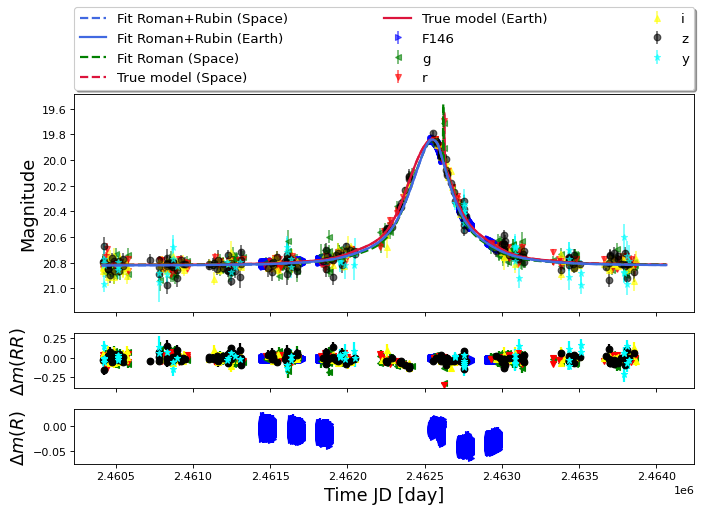

In [12]:
# magstar = {'W149':data["W149"], 'u':data["u"], 'g':data["g"], 'r':data["r"],
#                'i':data["i"], 'z':data["z"], 'y':data["Y"]}
ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
          'i':27.85, 'z':27.46, 'y':26.68}
colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
          'i':'yellow', 'z':'k', 'y':'cyan'}

i=18#18#34 cat B #18 good
nset=1
path_event = f'/home/anibal/results_roman_rubin/PB_new_format2/PB/set_sim{nset}/Event_{i}.h5'
path_fit_rr = f'/home/anibal/results_roman_rubin/PB_new_format2/PB/set_fit{nset}/Event_RR_{i}_TRF.npy'
path_fit_roman = f'/home/anibal/results_roman_rubin/PB_new_format2/PB/set_fit{nset}/Event_Roman_{i}_TRF.npy'
path_TRILEGAL = f"/home/anibal/results_roman_rubin/PB_planet_split_{nset}.csv"
model_ulens = 'USBL'

# path_event = f'/home/anibal/results_roman_rubin/FFP_final/FFP/set_sim{nset}/Event_{i}.h5'
# path_fit_rr = f'/home/anibal/results_roman_rubin/FFP_final/FFP/set_fit{nset}/Event_RR_{i}_TRF.npy'
# path_fit_roman = f'/home/anibal/results_roman_rubin/FFP_final/FFP/set_fit{nset}/Event_Roman_{i}_TRF.npy'
# path_TRILEGAL = f"/home/anibal/results_roman_rubin/FFP_uni_split_{nset}.csv"
# model_ulens = 'FSPL'

# path_event = f'/home/anibal/results_roman_rubin/BH_final/BH/set_sim{nset}/Event_{i}.h5'
# path_fit_rr = f'/home/anibal/results_roman_rubin/BH_final/BH/set_fit{nset}/Event_RR_{i}_TRF.npy'
# path_fit_roman = f'/home/anibal/results_roman_rubin/BH_final/BH/set_fit{nset}/Event_Roman_{i}_TRF.npy'
# path_TRILEGAL = f"/home/anibal/Downloads/BH_split_{nset}.csv"
# model_ulens = 'PSPL'

path_ephemerides = '/home/anibal/files_db/james_webb.txt'
path_dataslice = '/home/anibal/roman_rubin/simulation/dataSlice_baseline.npy'

info_dataset, pyLIMA_parameters, bands = read_data(path_event)
# print('pyLIMA_parameters saved -------------',pyLIMA_parameters)
data_fit_rr = np.load(path_fit_rr,allow_pickle=True).item()
data_fit_roman = np.load(path_fit_roman,allow_pickle=True).item()
pd_planets = pd.read_csv(path_TRILEGAL)
# print()
data = pd_planets.iloc[i]

my_own_model, pyLIMA_parameters, all_residuals, decision = sim_event(i, data, path_ephemerides, path_dataslice,model_ulens)
# print(('mass_ratio' and 'rho') in pyLIMA_parameters.keys())
# print('pyLIMA_parameters sim --------------',pyLIMA_parameters)

%matplotlib inline
# if decision:
plt.close('all')
# plt.figure(figsize=(8,7),dpi=75)
ylim,xlim = [21,21.6],[1,1]
axins = False
mat_figure, mat_figure_axes = plt.subplots(3, 1, sharex=True,figsize=(10, 6), dpi=80, gridspec_kw={'height_ratios': [4, 1, 1]})

plot_fits(mat_figure_axes,ylim,xlim,axins,my_own_model, pyLIMA_parameters, all_residuals, data_fit_rr, data_fit_roman)
    # plot_lightcurves(my_own_model, pyLIMA_parameters, all_residuals)
m1_rr = met_1_rr[met_1_rr['Source']==int(i + nset*5000)]
string_rr = 'Roman+Rubin:\n '
# lab = {'rho':'\rho', 'tE':'t_E'}
labels = {'t0':'t_0', 'u0':'u_0', 'tE':'t_E','rho':'\\rho', 's':'s', 'q':'q', 'alpha':'\\alpha', 'piE':'\pi_{E}', 'piEN':'\pi_{EN}'}
label_m1 = lambda p: r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|}{'+f'{labels[p]}'+'^{true}'+'}$'

# for p in ('tE','rho','piE'):
#     m1_p_rr = round(m1_rr[p].values[0],3)#round(abs(pyLIMA_parameters[p]-pyLIMA_parameters_rr[p])/pyLIMA_parameters[p],3)
#     string_rr+= label_m1(p)+f'={m1_p_rr}'+'     '

# mat_figure_axes[2].annotate(string_rr, 
#         xy=(0.5, -1.5), xycoords='axes fraction',
#         ha='center', va='center', fontsize=15)

# m1_roman = met_1_roman[met_1_roman['Source']==int(i + nset*5000)]
# string_roman = 'Roman:\n '
# for p in ('tE','rho','piE'):
#     m1_p_roman = round(m1_roman[p].values[0],3)#round(abs(pyLIMA_parameters[p]-pyLIMA_parameters_roman[p])/pyLIMA_parameters[p],3)
#     string_roman+= label_m1(p)+f'={m1_p_roman}'+'     '

# mat_figure_axes[2].annotate(string_roman, 
#         xy=(0.5, -3), xycoords='axes fraction',
#         ha='center', va='center', fontsize=15)

4
4789
u         2.897400e+01
g         2.587400e+01
r         2.451400e+01
i         2.313700e+01
z         2.246200e+01
Y         2.216700e+01
W149      2.207780e+01
radius    4.184592e-01
D_S       7.571000e+03
D_L       6.756000e+03
mu_rel    2.906595e+00
t0        2.462211e+06
te        3.568840e+02
u0        2.452248e-01
rho       9.050554e-05
piEE     -5.206132e-03
piEN      2.091103e-03
Name: 4789, dtype: float64


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: Erf

Parallax(Full) estimated for the telescope W149: SUCCESS
Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
[2462210.839002816, 0.2452248400858135, 356.88396067604, 0.0020911034107683, -0.0052061321626452, 108.1567151157597, 164.0136524114438, 0.1009289980736277, 0.16687835113653923, 6.358571222224377, 10.055415018560437, 28.229660445487212, 28.73425886674873, 74.3158394728982, 76.77149537690289, 51.24616378580644, 99.81596274917254, 47.56520709193318, 63.855748507883845]
A good event to fit


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133

Parallax(Full) estimated for the telescope W149: SUCCESS
Parallax(Full) estimated for the telescope u: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
OrderedDict([('t0', 2462210.839002816), ('u0', 0.2452248400858135), ('tE', 356.88396067604), ('piEN', 0.0020911034107683), ('piEE', -0.0052061321626452), ('fsource_W149', 108.1567151157597), ('ftotal_W149', 164.0136524114438), ('fsource_u', 108.1567151157597), ('ftotal_u', 164.0136524114438), ('fsource_g', 108.1567151157597), ('ftotal_g', 164.0136524114438), ('fsource_r', 108.1567151157597), ('ftotal_r', 164.0136524114438), ('fsource_i', 108.1567151157597), ('ftotal_i', 164.0136524114438), ('fsource_z', 108.1567151157597), ('ftotal_z', 164.0136524114438), ('fsource_y', 108.1567151157597), ('ftotal_y', 164.013652

/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 23491 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 23491 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope W149: SUCCESS


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 23491 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope W149: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope W149: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS


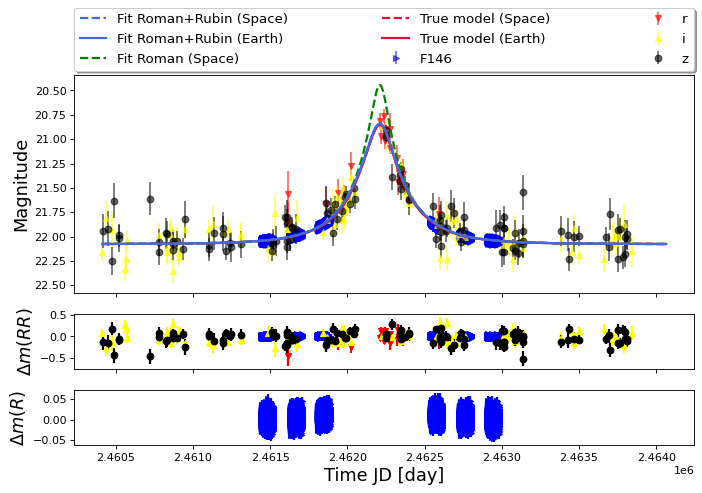

In [13]:
ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
          'i':27.85, 'z':27.46, 'y':26.68}
colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
          'i':'yellow', 'z':'k', 'y':'cyan'}

i=24789#34 cat B #18 good
nset=int(i/5000)
print(nset)
print(i-5000*nset)
# path_event = f'/home/anibal/results_roman_rubin/PB_new_format2/PB/set_sim{nset}/Event_{i}.h5'
# path_fit_rr = f'/home/anibal/results_roman_rubin/PB_new_format2/PB/set_fit{nset}/Event_RR_{i}_TRF.npy'
# path_fit_roman = f'/home/anibal/results_roman_rubin/PB_new_format2/PB/set_fit{nset}/Event_Roman_{i}_TRF.npy'
# path_TRILEGAL = f"/home/anibal/results_roman_rubin/PB_planet_split_{nset}.csv"
# model_ulens = 'USBL'

# path_event = f'/home/anibal/results_roman_rubin/FFP_final/FFP/set_sim{nset}/Event_{i}.h5'
# path_fit_rr = f'/home/anibal/results_roman_rubin/FFP_final/FFP/set_fit{nset}/Event_RR_{i}_TRF.npy'
# path_fit_roman = f'/home/anibal/results_roman_rubin/FFP_final/FFP/set_fit{nset}/Event_Roman_{i}_TRF.npy'
# path_TRILEGAL = f"/home/anibal/results_roman_rubin/FFP_uni_split_{nset}.csv"
# model_ulens = 'FSPL'

path_event = f'/home/anibal/results_roman_rubin/BH_final/BH/set_sim{nset}/Event_{i-5000*nset}.h5'
# print(os.listdir(path_event))
path_fit_rr = f'/home/anibal/results_roman_rubin/BH_final/BH/set_fit{nset}/Event_RR_{i-5000*nset}_TRF.npy'
path_fit_roman = f'/home/anibal/results_roman_rubin/BH_final/BH/set_fit{nset}/Event_Roman_{i-5000*nset}_TRF.npy'
path_TRILEGAL = f"/home/anibal/roman_rubin/TRILEGAL/BH_split_{nset}.csv"
model_ulens = 'PSPL'

path_ephemerides = '/home/anibal/files_db/Gaia.txt'
path_dataslice = '/home/anibal/roman_rubin/simulation/dataSlice_baseline.npy'

info_dataset, pyLIMA_parameters, bands = read_data(path_event)
# print('pyLIMA_parameters saved -------------',pyLIMA_parameters)
data_fit_rr = np.load(path_fit_rr,allow_pickle=True).item()
data_fit_roman = np.load(path_fit_roman,allow_pickle=True).item()
pd_planets = pd.read_csv(path_TRILEGAL)
# print()
data = pd_planets.iloc[i-5000*nset]
print(data)
my_own_model, pyLIMA_parameters, all_residuals, decision = sim_event(i, data, path_ephemerides, path_dataslice,model_ulens)
# print(('mass_ratio' and 'rho') in pyLIMA_parameters.keys())
# print('pyLIMA_parameters sim --------------',pyLIMA_parameters)

%matplotlib inline
# if decision:
plt.close('all')
# plt.figure(figsize=(8,7),dpi=75)
ylim,xlim = [19.5,20.2],[1,1]
mat_figure, mat_figure_axes = plt.subplots(3, 1, sharex=True,figsize=(10, 6), dpi=80, gridspec_kw={'height_ratios': [4, 1, 1]})
axins=False
plot_fits(mat_figure_axes,ylim,xlim,axins,my_own_model, pyLIMA_parameters, all_residuals, data_fit_rr, data_fit_roman)

# plot_lightcurves(my_own_model, pyLIMA_parameters, all_residuals)
# m1_rr = met_1_rr[met_1_rr['Source']==int(i + nset*5000)]
# string_rr = 'Roman+Rubin:\n '
# # lab = {'rho':'\rho', 'tE':'t_E'}
# labels = {'t0':'t_0', 'u0':'u_0', 'tE':'t_E','rho':'\\rho', 's':'s', 'q':'q', 'alpha':'\\alpha', 'piE':'\pi_{E}', 'piEN':'\pi_{EN}'}
# label_m1 = lambda p: r'$\frac{|'+f'{labels[p]}'+'^{true}-'+f'{labels[p]}'+'^{fit}|}{'+f'{labels[p]}'+'^{true}'+'}$'

# for p in ('tE','rho','piE'):
#     m1_p_rr = round(m1_rr[p].values[0],3)#round(abs(pyLIMA_parameters[p]-pyLIMA_parameters_rr[p])/pyLIMA_parameters[p],3)
#     string_rr+= label_m1(p)+f'={m1_p_rr}'+'     '

# mat_figure_axes[2].annotate(string_rr, 
#         xy=(0.5, -1.5), xycoords='axes fraction',
#         ha='center', va='center', fontsize=15)

# m1_roman = met_1_roman[met_1_roman['Source']==int(i + nset*5000)]
# string_roman = 'Roman:\n '
# for p in ('tE','rho','piE'):
#     m1_p_roman = round(m1_roman[p].values[0],3)#round(abs(pyLIMA_parameters[p]-pyLIMA_parameters_roman[p])/pyLIMA_parameters[p],3)
#     string_roman+= label_m1(p)+f'={m1_p_roman}'+'     '

# mat_figure_axes[2].annotate(string_roman, 
#         xy=(0.5, -3), xycoords='axes fraction',
#         ha='center', va='center', fontsize=15)